In [1]:
#Enable API here: https://console.cloud.google.com/apis/api/earthengine.googleapis.com
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-hungweipan2')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class FirePredictionModel:
    def __init__(self, roi_name, country_name):
        self.roi = ee.FeatureCollection("FAO/GAUL/2015/level1") \
                    .filter(ee.Filter.eq('ADM1_NAME', roi_name)) \
                    .filter(ee.Filter.eq('ADM0_NAME', country_name))

    def process_monthly_data(self, year, month):
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        # Fire data (label)
        fire = ee.ImageCollection('MODIS/061/MOD14A1') \
            .filterBounds(self.roi) \
            .filterDate(start_date, end_date) \
            .max() \
            .select('FireMask') \
            .expression("(b('FireMask') == 7 || b('FireMask') == 8 || b('FireMask') == 9) ? 1 : 0") \
            .rename('FireOccurred') \
            .toFloat()

        # NDVI data
        ndvi = ee.ImageCollection('MODIS/061/MOD13A2') \
            .filterBounds(self.roi) \
            .filterDate(start_date, end_date) \
            .mean() \
            .select('NDVI') \
            .multiply(0.0001) \
            .toFloat()

        # Weather data
        weather = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .filterBounds(self.roi) \
            .filterDate(start_date, end_date) \
            .mean() \
            .select([
                'temperature_2m',
                'dewpoint_temperature_2m',
                'u_component_of_wind_10m',
                'v_component_of_wind_10m'
            ])
        wind_speed = weather.expression(
            'sqrt(u**2 + v**2)', {
                'u': weather.select('u_component_of_wind_10m'),
                'v': weather.select('v_component_of_wind_10m')
            }
        ).rename('wind_speed')

        relative_humidity = weather.expression(
            '100 * (6.11 * pow(10, (7.5 * dew) / (237.7 + dew))) / (6.11 * pow(10, (7.5 * temp) / (237.7 + temp)))', {
                'temp': weather.select('temperature_2m').subtract(273.15),  # Convert to Celsius
                'dew': weather.select('dewpoint_temperature_2m').subtract(273.15)  # Convert to Celsius
            })


        # DEM data
        dem = ee.ImageCollection('NRCan/CDEM').mosaic().clip(self.roi).toFloat().rename('DEM')

        # Combine image
        combined = fire \
            .addBands(ndvi.rename('NDVI')) \
            .addBands(weather.select(['temperature_2m']).subtract(273.15).rename(['temp'])) \
            .addBands(relative_humidity) \
            .addBands(wind_speed) \
            .addBands(dem)
        return combined

    def collect_training_data(self, years, months, scale=10000):
        training_data = []
        for year in years:
            for month in months:
                image = self.process_monthly_data(year, month)
                samples = image.sample(
                    region=self.roi.geometry(),
                    scale=scale,
                    geometries=True
                )
                training_data.append(samples)
        return ee.FeatureCollection(training_data).flatten()


    def export_training_data(self, training_data, description, file_format='CSV'):
        task = ee.batch.Export.table.toDrive(
            collection=training_data,
            description=description,
            fileFormat=file_format
        )
        task.start()

# Initialize the model
model = FirePredictionModel(roi_name='Alberta', country_name='Canada')

# Define years and months
years = list(range(2015, 2023))
months = list(range(5, 10))

# Collect training data
training_data = model.collect_training_data(years, months)
# testing_data = model.collect_training_data([2024], months)

# Export training data to Google Drive
# model.export_training_data(training_data, description='TrainingData2020_2023_5_10_coor')
# model.export_training_data(testing_data, description='TestingData2024_5_10_coor')
# model.export_training_data(training_data, description='TrainingData2015_2024_5_10_coor')
model.export_training_data(training_data, description='TrainingData2015_2023_5_10_coor')

print("Random Forest model training completed, and the training data export has started.")


Random Forest model training completed, and the training data export has started.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [34]:
# data = pd.read_csv('/content/drive/MyDrive/TrainingData2023_5_10.csv')
# data = pd.read_csv('/content/drive/MyDrive/TrainingData2020_2023_5_10.csv')
# data = pd.read_csv('/content/drive/MyDrive/TrainingData2020_2023_5_10_coor.csv')
data = pd.read_csv('/content/drive/MyDrive/TrainingData2015_2024_5_10_coor.csv')
# data = pd.read_csv('/content/drive/MyDrive/fp-historical-wildfire-data-2006-2023.csv')
# data = pd.read_csv('/content/drive/MyDrive/TrainingData2015_2023_5_10_coor_5000.csv')
# data = pd.read_csv('/content/drive/MyDrive/TrainingData2015_2023_5_10_coor.csv')
# test_data = pd.read_csv('/content/drive/MyDrive/TestingData2024_5_10_coor.csv')
# print(testing_data)
print(data.shape)

(521415, 8)


In [35]:
data.columns

Index(['system:index', 'DEM', 'FireOccurred', 'NDVI', 'constant', 'temp',
       'wind_speed', '.geo'],
      dtype='object')

In [36]:
# downsample some non-fire data
no_fire_data = data[data['FireOccurred']==0]
fire_data = data[data['FireOccurred']==1]
print(fire_data.shape)

no_fire_index = np.arange(no_fire_data.shape[0])
random.shuffle(no_fire_index)

remain_no_fire_index = no_fire_index[0:len(fire_data)]
no_fire_data = no_fire_data.iloc[remain_no_fire_index]

data = pd.concat([no_fire_data, fire_data])

print(data)

(1272, 8)
       system:index    DEM  FireOccurred     NDVI   constant       temp  \
517886      44_8058  651.0           0.0  0.49510  58.114108  12.605311   
284476      24_6388  516.0           0.0  0.45845  71.486003  10.831086   
461957     39_10064  379.0           0.0  0.59775  62.959104  12.910680   
290205       25_530  831.0           0.0  0.33600  55.724488  11.337686   
231254     19_11101  301.0           0.0  0.54270  63.827842   3.377119   
...             ...    ...           ...      ...        ...        ...   
521313     44_11485  620.0           1.0  0.47795  64.146293  11.589697   
521314     44_11486  609.0           1.0  0.47795  63.797939  11.629158   
521350     44_11522  303.0           1.0  0.57210  64.119583  13.326982   
521351     44_11523  298.0           1.0  0.57210  64.131354  13.328987   
521352     44_11524  293.0           1.0  0.57210  64.131354  13.328987   

        wind_speed                                               .geo  
517886    1.24088

In [37]:
# split dataset
X = data.drop('FireOccurred', axis=1)
y = data['FireOccurred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
X_train_refine = X_train.drop(['system:index', '.geo'], axis=1)
X_test_refine = X_test.drop(['system:index', '.geo'], axis=1)

In [39]:
# class weight
no_fire = y_train.value_counts()[0]
fire = y_train.value_counts()[1]

class_weight = {0: no_fire / (no_fire + fire), 1: fire / (no_fire + fire)}
# class_weight = {0: 0.3333, 1: 0.66666}
print(class_weight)

{0: 0.501123595505618, 1: 0.49887640449438203}


In [40]:
# random forest classifier model
# rf = RandomForestClassifier(n_estimators=90, criterion='gini', random_state=42, class_weight=class_weight)
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)

rf.fit(X_train_refine, y_train)

y_pred = rf.predict(X_test_refine)

In [ ]:
# gradient boosting machine
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_refine, y_train)

y_pred = gb.predict(X_test_refine)

In [ ]:
from xgboost import XGBClassifier

# Create regression matrices
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.01,
                          max_depth=0, objective='binary:logitraw',
                          scale_pos_weight=10, random_state=42)
xgb_model.fit(X_train_refine, y_train)

y_pred = xgb_model.predict(X_test_refine)

In [ ]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', class_weight=class_weight)
svm_model.fit(X_train_refine, y_train)

y_pred = svm_model.predict(X_test_refine)

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87       380
         1.0       0.87      0.89      0.88       384

    accuracy                           0.88       764
   macro avg       0.88      0.88      0.88       764
weighted avg       0.88      0.88      0.88       764



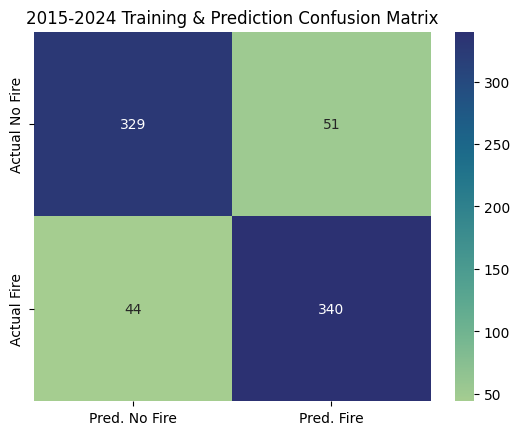

In [41]:
cm = confusion_matrix(y_test, y_pred)
cm_pd = pd.DataFrame(cm, columns=['Pred. No Fire', 'Pred. Fire'], index=['Actual No Fire', 'Actual Fire'])
ax = plt.axes()
sns.heatmap(cm_pd, annot=True, fmt='d', cmap='crest', ax=ax)
ax.set_title('2015-2024 Training & Prediction Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)

In [12]:
data = pd.read_csv('/content/drive/MyDrive/TrainingData2015_2023_5_10_coor.csv')
test_data = pd.read_csv('/content/drive/MyDrive/TestingData2024_5_10_coor.csv')
print(data.shape)

(463480, 8)


In [13]:
# downsample some non-fire data
no_fire_data = data[data['FireOccurred']==0]
fire_data = data[data['FireOccurred']==1]
print(fire_data.shape)

no_fire_index = np.arange(no_fire_data.shape[0])
random.shuffle(no_fire_index)

remain_no_fire_index = no_fire_index[0:len(fire_data)]
no_fire_data = no_fire_data.iloc[remain_no_fire_index]

data = pd.concat([no_fire_data, fire_data])

print(data)

(558, 8)
       system:index    DEM  FireOccurred     NDVI   constant       temp  \
157712      13_7081  551.0           0.0  0.72210  64.433732  16.872682   
219901     18_11335  256.0           0.0  0.69510  56.379399  15.973875   
238712      20_6972  582.0           0.0  0.55315  44.232472  10.622187   
287581      24_9493  489.0           0.0  0.52090  69.035838  10.028340   
42890        3_8129  298.0           0.0  0.69835  62.085788  17.455041   
...             ...    ...           ...      ...        ...        ...   
449837      38_9531  256.0           1.0  0.75880  61.110356  19.229084   
449838      38_9532  259.0           1.0  0.75880  61.211996  19.197133   
462811     39_10918  303.0           1.0  0.55260  67.909508  12.845202   
462812     39_10919  323.0           1.0  0.55260  68.445725  12.918441   
462813     39_10920  306.0           1.0  0.55260  69.110396  13.021957   

        wind_speed                                               .geo  
157712    1.308506

In [14]:
# split dataset
X_train = data.drop('FireOccurred', axis=1)
y_train = data['FireOccurred']

X_test = test_data.drop('FireOccurred', axis=1)
y_test = test_data['FireOccurred']

In [15]:
X_train_refine = X_train.drop(['system:index', '.geo'], axis=1)
X_test_refine = X_test.drop(['system:index', '.geo'], axis=1)

In [16]:
# class weight
no_fire = y_train.value_counts()[0]
fire = y_train.value_counts()[1]

class_weight = {0: no_fire / (no_fire + fire), 1: fire / (no_fire + fire)}
# class_weight = {0: 0.3333, 1: 0.66666}
print(class_weight)

{0: 0.5, 1: 0.5}


In [17]:
# random forest classifier model
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)

rf.fit(X_train_refine, y_train)

y_pred = rf.predict(X_test_refine)

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     57748
         1.0       0.01      0.16      0.01       187

    accuracy                           0.91     57935
   macro avg       0.50      0.54      0.48     57935
weighted avg       0.99      0.91      0.95     57935



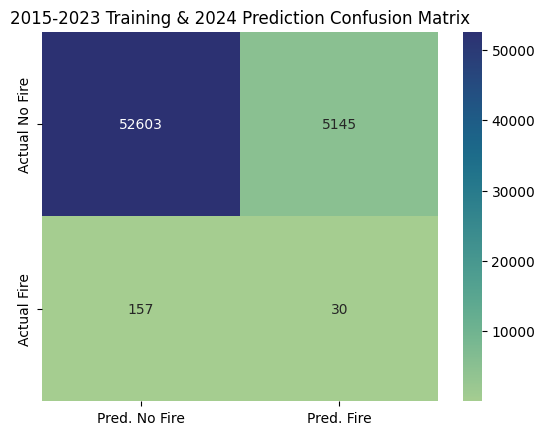

In [19]:
cm = confusion_matrix(y_test, y_pred)
cm_pd = pd.DataFrame(cm, columns=['Pred. No Fire', 'Pred. Fire'], index=['Actual No Fire', 'Actual Fire'])

ax = plt.axes()
sns.heatmap(cm_pd, annot=True, fmt='d', cmap='crest', ax=ax)
ax.set_title('2015-2023 Training & 2024 Prediction Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)